# Multi-Output CNN for Side-Channel Analysis
- ASCAD Dataset with de-synchronization countermeasures
- CNN exploits translation-invariance to handle random shifts
- 256 key guesses, each with its own branch
- LSB leakage model: $L_k = \text{Sbox}[P \oplus k] \mod 2$

# 1. Imports


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.config import (
    CNN_LEARNING_RATE, CNN_FILTERS, CNN_KERNEL_1, CNN_KERNEL_2,
    CNN_POOL_1, CNN_POOL_2, CNN_INPUT_SIZE, CNN_BATCH_SIZE,
    NUM_TRACES, TRACE_START_IDX, TARGET_BYTE_IDX, CNN_NUM_EPOCHS,
    FILE_PATH, CHECKPOINT_DIR
)
from src.cnn_model import CNNMultiOutputNet
from src.experiment import ExperimentManager
from src.utils import load_ascad, normalize_traces, generate_labels

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 2. Configuration


In [2]:
print("CNN Configuration:")
print(f"  CNN_FILTERS:    {CNN_FILTERS}")
print(f"  CNN_KERNEL_1:   {CNN_KERNEL_1}")
print(f"  CNN_KERNEL_2:   {CNN_KERNEL_2}")
print(f"  CNN_POOL_1:     {CNN_POOL_1}")
print(f"  CNN_POOL_2:     {CNN_POOL_2}")
print(f"  CNN_INPUT_SIZE: {CNN_INPUT_SIZE}")
print(f"  CNN_BATCH_SIZE: {CNN_BATCH_SIZE}")
print(f"  CNN_NUM_EPOCHS: {CNN_NUM_EPOCHS}")
print(f"  NUM_TRACES:     {NUM_TRACES}")
print()
print("OneCycleLR Schedule:")
print(f"  Base LR:        {CNN_LEARNING_RATE}")
print(f"  Max LR:         {CNN_LEARNING_RATE * 10} (10× base)")
print(f"  Warmup:         30% of training")
print(f"  Final LR:       {CNN_LEARNING_RATE / 25:.2e} (base/25)")


CNN Configuration:
  CNN_FILTERS:    4
  CNN_KERNEL_1:   32
  CNN_KERNEL_2:   16
  CNN_POOL_1:     2
  CNN_POOL_2:     4
  CNN_INPUT_SIZE: 480
  CNN_BATCH_SIZE: 50
  CNN_NUM_EPOCHS: 50
  NUM_TRACES:     10000

OneCycleLR Schedule:
  Base LR:        0.0001
  Max LR:         0.001 (10× base)
  Warmup:         30% of training
  Final LR:       4.00e-06 (base/25)


## 3. Dataset Loading


In [3]:
traces, plaintexts, real_key = load_ascad(
    FILE_PATH, 
    num_traces=NUM_TRACES, 
    start_idx=TRACE_START_IDX, 
    target_byte=TARGET_BYTE_IDX
)

# Slice to CNN input size and normalize
traces = traces[:, :CNN_INPUT_SIZE]
traces_tensor = normalize_traces(traces)
print("Traces shape:", traces_tensor.shape)
print("Real Key Byte:", hex(real_key))


Traces shape: torch.Size([10000, 480])
Real Key Byte: 0xe0


## 4. Label Generation


In [4]:
labels_tensor = generate_labels(plaintexts)
print("Labels shape:", labels_tensor.shape)


Labels shape: torch.Size([10000, 256])


## 5. CNN Model Architecture

- Shared: Conv(4x32) → BN → AvgPool(2) → ReLU → Conv(4x16) → BN → AvgPool(4) → ReLU
- 256 Branches: Flatten → Dense(2) with Softmax


In [5]:
model = CNNMultiOutputNet(
    input_size=CNN_INPUT_SIZE,
    filters=CNN_FILTERS,
    kernel1=CNN_KERNEL_1,
    kernel2=CNN_KERNEL_2,
    pool1=CNN_POOL_1,
    pool2=CNN_POOL_2
).to(device)

print(f"CNN model created with input_size={CNN_INPUT_SIZE}, flat_size={model.flat_size}")


CNN model created with input_size=480, flat_size=208


## 6. Training Loop

- Loss: $\mathcal{L}_{total} = \frac{1}{256}\sum_{k=1}^{256} \mathcal{L}^{[k]}$ (cross-entropy per branch)
- Optimizer: Adam with **OneCycleLR** scheduler
- LR Schedule: Warmup → Peak (10× base) → Cosine annealing → Final (base/25)


In [6]:
dataset = TensorDataset(traces_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=CNN_BATCH_SIZE, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CNN_LEARNING_RATE)

# OneCycleLR: warmup → peak → cosine decay
# max_lr = 10x base, div_factor=10 (start at base), final_div_factor=25 (end at base/25)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CNN_LEARNING_RATE * 10,
    epochs=CNN_NUM_EPOCHS,
    steps_per_epoch=len(loader),
    pct_start=0.3,           # 30% warmup
    anneal_strategy='cos',   # cosine annealing
    div_factor=10,           # initial_lr = max_lr / 10
    final_div_factor=25      # final_lr = initial_lr / 25
)

key_scores = np.zeros((CNN_NUM_EPOCHS, 256))
lr_history = []

for epoch in range(CNN_NUM_EPOCHS):
    model.train()
    total_loss = 0
    epoch_lrs = []
    
    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{CNN_NUM_EPOCHS}')
    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = sum(criterion(output[:, k, :], target[:, k]) for k in range(256)) / 256
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update LR after each batch
        
        total_loss += loss.item()
        epoch_lrs.append(scheduler.get_last_lr()[0])
        
    avg_lr = np.mean(epoch_lrs)
    lr_history.extend(epoch_lrs)
    print(f"Epoch {epoch+1} Avg Loss: {total_loss / len(loader):.6f} | LR: {avg_lr:.2e}")
    
    # Validation: compute loss per branch
    model.eval()
    with torch.no_grad():
        val_accum_loss = torch.zeros(256, device=device)
        val_count = 0
        
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            out = model(data)
            
            for k in range(256):
                val_accum_loss[k] += nn.CrossEntropyLoss(reduction='sum')(out[:, k, :], target[:, k])
            val_count += data.size(0)
            
        avg_branch_losses = val_accum_loss / val_count
        key_scores[epoch] = -avg_branch_losses.cpu().numpy()
        
        sorted_keys = np.argsort(key_scores[epoch])[::-1]
        best_key = sorted_keys[0]
        rank_of_real = np.where(sorted_keys == real_key)[0][0]
        
        print(f"Best Key: {hex(best_key)}, Real Key Rank: {rank_of_real}")


Epoch 1/50: 100%|██████████| 200/200 [00:18<00:00, 10.91it/s]


Epoch 1 Avg Loss: 0.726323 | LR: 1.03e-04
Best Key: 0xe7, Real Key Rank: 17


Epoch 2/50: 100%|██████████| 200/200 [00:17<00:00, 11.68it/s]


Epoch 2 Avg Loss: 0.705611 | LR: 1.23e-04
Best Key: 0xe7, Real Key Rank: 17


Epoch 3/50: 100%|██████████| 200/200 [00:17<00:00, 11.57it/s]


Epoch 3 Avg Loss: 0.700856 | LR: 1.61e-04
Best Key: 0xe7, Real Key Rank: 20


Epoch 4/50: 100%|██████████| 200/200 [00:23<00:00,  8.49it/s]


Epoch 4 Avg Loss: 0.698192 | LR: 2.16e-04
Best Key: 0xe7, Real Key Rank: 20


Epoch 5/50: 100%|██████████| 200/200 [00:23<00:00,  8.44it/s]


Epoch 5 Avg Loss: 0.696336 | LR: 2.86e-04
Best Key: 0xe7, Real Key Rank: 28


Epoch 6/50: 100%|██████████| 200/200 [00:23<00:00,  8.52it/s]


Epoch 6 Avg Loss: 0.694985 | LR: 3.68e-04
Best Key: 0x5c, Real Key Rank: 30


Epoch 7/50: 100%|██████████| 200/200 [00:23<00:00,  8.56it/s]


Epoch 7 Avg Loss: 0.694073 | LR: 4.57e-04
Best Key: 0xe7, Real Key Rank: 23


Epoch 8/50: 100%|██████████| 200/200 [00:23<00:00,  8.59it/s]


Epoch 8 Avg Loss: 0.693475 | LR: 5.50e-04
Best Key: 0x5c, Real Key Rank: 35


Epoch 9/50: 100%|██████████| 200/200 [00:17<00:00, 11.62it/s]


Epoch 9 Avg Loss: 0.693102 | LR: 6.44e-04
Best Key: 0x5c, Real Key Rank: 26


Epoch 10/50: 100%|██████████| 200/200 [00:17<00:00, 11.68it/s]


Epoch 10 Avg Loss: 0.692819 | LR: 7.33e-04
Best Key: 0x5c, Real Key Rank: 52


Epoch 11/50: 100%|██████████| 200/200 [00:17<00:00, 11.71it/s]


Epoch 11 Avg Loss: 0.692568 | LR: 8.14e-04
Best Key: 0x5c, Real Key Rank: 44


Epoch 12/50: 100%|██████████| 200/200 [00:17<00:00, 11.55it/s]


Epoch 12 Avg Loss: 0.692306 | LR: 8.84e-04
Best Key: 0xd3, Real Key Rank: 35


Epoch 13/50: 100%|██████████| 200/200 [00:17<00:00, 11.74it/s]


Epoch 13 Avg Loss: 0.692010 | LR: 9.39e-04
Best Key: 0x32, Real Key Rank: 34


Epoch 14/50: 100%|██████████| 200/200 [00:17<00:00, 11.42it/s]


Epoch 14 Avg Loss: 0.691669 | LR: 9.77e-04
Best Key: 0x32, Real Key Rank: 46


Epoch 15/50: 100%|██████████| 200/200 [00:17<00:00, 11.11it/s]


Epoch 15 Avg Loss: 0.691269 | LR: 9.97e-04
Best Key: 0xd3, Real Key Rank: 29


Epoch 16/50: 100%|██████████| 200/200 [00:17<00:00, 11.60it/s]


Epoch 16 Avg Loss: 0.690860 | LR: 9.99e-04
Best Key: 0x32, Real Key Rank: 26


Epoch 17/50: 100%|██████████| 200/200 [00:17<00:00, 11.39it/s]


Epoch 17 Avg Loss: 0.690390 | LR: 9.95e-04
Best Key: 0xd3, Real Key Rank: 20


Epoch 18/50: 100%|██████████| 200/200 [00:17<00:00, 11.33it/s]


Epoch 18 Avg Loss: 0.689943 | LR: 9.87e-04
Best Key: 0xd3, Real Key Rank: 43


Epoch 19/50: 100%|██████████| 200/200 [00:17<00:00, 11.32it/s]


Epoch 19 Avg Loss: 0.689480 | LR: 9.75e-04
Best Key: 0xd3, Real Key Rank: 50


Epoch 20/50: 100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


Epoch 20 Avg Loss: 0.689006 | LR: 9.60e-04
Best Key: 0x32, Real Key Rank: 35


Epoch 21/50: 100%|██████████| 200/200 [00:17<00:00, 11.29it/s]


Epoch 21 Avg Loss: 0.688589 | LR: 9.40e-04
Best Key: 0x32, Real Key Rank: 17


Epoch 22/50: 100%|██████████| 200/200 [00:17<00:00, 11.28it/s]


Epoch 22 Avg Loss: 0.688150 | LR: 9.17e-04
Best Key: 0xc5, Real Key Rank: 65


Epoch 23/50: 100%|██████████| 200/200 [00:17<00:00, 11.40it/s]


Epoch 23 Avg Loss: 0.687738 | LR: 8.91e-04
Best Key: 0xc5, Real Key Rank: 70


Epoch 24/50: 100%|██████████| 200/200 [00:17<00:00, 11.67it/s]


Epoch 24 Avg Loss: 0.687319 | LR: 8.62e-04
Best Key: 0x5e, Real Key Rank: 79


Epoch 25/50: 100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


Epoch 25 Avg Loss: 0.686963 | LR: 8.29e-04
Best Key: 0x5e, Real Key Rank: 61


Epoch 26/50: 100%|██████████| 200/200 [00:17<00:00, 11.66it/s]


Epoch 26 Avg Loss: 0.686686 | LR: 7.94e-04
Best Key: 0xc5, Real Key Rank: 45


Epoch 27/50: 100%|██████████| 200/200 [00:17<00:00, 11.46it/s]


Epoch 27 Avg Loss: 0.686349 | LR: 7.57e-04
Best Key: 0x32, Real Key Rank: 30


Epoch 28/50: 100%|██████████| 200/200 [00:17<00:00, 11.61it/s]


Epoch 28 Avg Loss: 0.686057 | LR: 7.18e-04
Best Key: 0x7a, Real Key Rank: 20


Epoch 29/50: 100%|██████████| 200/200 [00:17<00:00, 11.33it/s]


Epoch 29 Avg Loss: 0.685805 | LR: 6.77e-04
Best Key: 0x5e, Real Key Rank: 34


Epoch 30/50: 100%|██████████| 200/200 [00:16<00:00, 11.78it/s]


Epoch 30 Avg Loss: 0.685538 | LR: 6.34e-04
Best Key: 0x5e, Real Key Rank: 42


Epoch 31/50: 100%|██████████| 200/200 [00:16<00:00, 11.79it/s]


Epoch 31 Avg Loss: 0.685302 | LR: 5.91e-04
Best Key: 0x5e, Real Key Rank: 57


Epoch 32/50: 100%|██████████| 200/200 [00:17<00:00, 11.72it/s]


Epoch 32 Avg Loss: 0.685072 | LR: 5.46e-04
Best Key: 0x32, Real Key Rank: 25


Epoch 33/50: 100%|██████████| 200/200 [00:17<00:00, 11.73it/s]


Epoch 33 Avg Loss: 0.684885 | LR: 5.02e-04
Best Key: 0xc5, Real Key Rank: 68


Epoch 34/50: 100%|██████████| 200/200 [00:17<00:00, 11.71it/s]


Epoch 34 Avg Loss: 0.684669 | LR: 4.57e-04
Best Key: 0x7a, Real Key Rank: 40


Epoch 35/50: 100%|██████████| 200/200 [00:17<00:00, 11.71it/s]


Epoch 35 Avg Loss: 0.684516 | LR: 4.13e-04
Best Key: 0x5e, Real Key Rank: 69


Epoch 36/50: 100%|██████████| 200/200 [00:17<00:00, 11.70it/s]


Epoch 36 Avg Loss: 0.684340 | LR: 3.69e-04
Best Key: 0xc5, Real Key Rank: 52


Epoch 37/50: 100%|██████████| 200/200 [00:17<00:00, 11.75it/s]


Epoch 37 Avg Loss: 0.684190 | LR: 3.27e-04
Best Key: 0x7a, Real Key Rank: 62


Epoch 38/50: 100%|██████████| 200/200 [00:16<00:00, 11.78it/s]


Epoch 38 Avg Loss: 0.684029 | LR: 2.86e-04
Best Key: 0xc5, Real Key Rank: 36


Epoch 39/50: 100%|██████████| 200/200 [00:17<00:00, 11.74it/s]


Epoch 39 Avg Loss: 0.683926 | LR: 2.46e-04
Best Key: 0x7a, Real Key Rank: 53


Epoch 40/50: 100%|██████████| 200/200 [00:17<00:00, 11.33it/s]


Epoch 40 Avg Loss: 0.683790 | LR: 2.09e-04
Best Key: 0xc5, Real Key Rank: 52


Epoch 41/50: 100%|██████████| 200/200 [00:16<00:00, 11.92it/s]


Epoch 41 Avg Loss: 0.683664 | LR: 1.74e-04
Best Key: 0xc5, Real Key Rank: 55


Epoch 42/50: 100%|██████████| 200/200 [00:17<00:00, 11.75it/s]


Epoch 42 Avg Loss: 0.683591 | LR: 1.42e-04
Best Key: 0x7a, Real Key Rank: 60


Epoch 43/50: 100%|██████████| 200/200 [00:16<00:00, 11.79it/s]


Epoch 43 Avg Loss: 0.683484 | LR: 1.13e-04
Best Key: 0x7a, Real Key Rank: 63


Epoch 44/50: 100%|██████████| 200/200 [00:16<00:00, 11.83it/s]


Epoch 44 Avg Loss: 0.683400 | LR: 8.63e-05
Best Key: 0x7a, Real Key Rank: 64


Epoch 45/50: 100%|██████████| 200/200 [00:17<00:00, 11.76it/s]


Epoch 45 Avg Loss: 0.683347 | LR: 6.35e-05
Best Key: 0x7a, Real Key Rank: 61


Epoch 46/50: 100%|██████████| 200/200 [00:17<00:00, 11.61it/s]


Epoch 46 Avg Loss: 0.683286 | LR: 4.41e-05
Best Key: 0x7a, Real Key Rank: 58


Epoch 47/50: 100%|██████████| 200/200 [00:17<00:00, 11.68it/s]


Epoch 47 Avg Loss: 0.683228 | LR: 2.84e-05
Best Key: 0xc5, Real Key Rank: 61


Epoch 48/50: 100%|██████████| 200/200 [00:16<00:00, 11.85it/s]


Epoch 48 Avg Loss: 0.683197 | LR: 1.66e-05
Best Key: 0x7a, Real Key Rank: 65


Epoch 49/50: 100%|██████████| 200/200 [00:17<00:00, 11.70it/s]


Epoch 49 Avg Loss: 0.683175 | LR: 8.63e-06
Best Key: 0x7a, Real Key Rank: 60


Epoch 50/50: 100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


Epoch 50 Avg Loss: 0.683180 | LR: 4.65e-06
Best Key: 0x7a, Real Key Rank: 68


## 7. Results Analysis


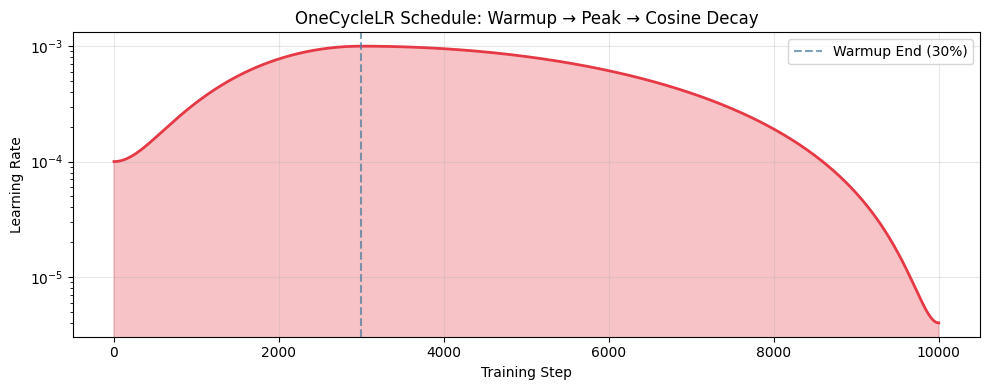

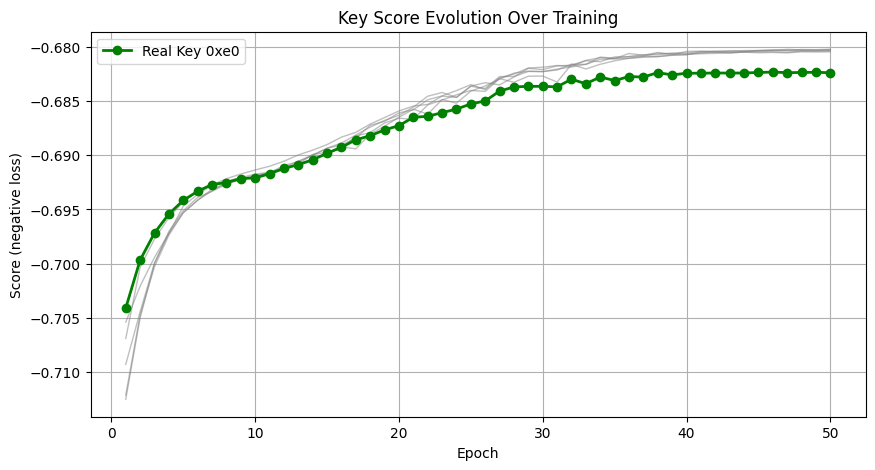

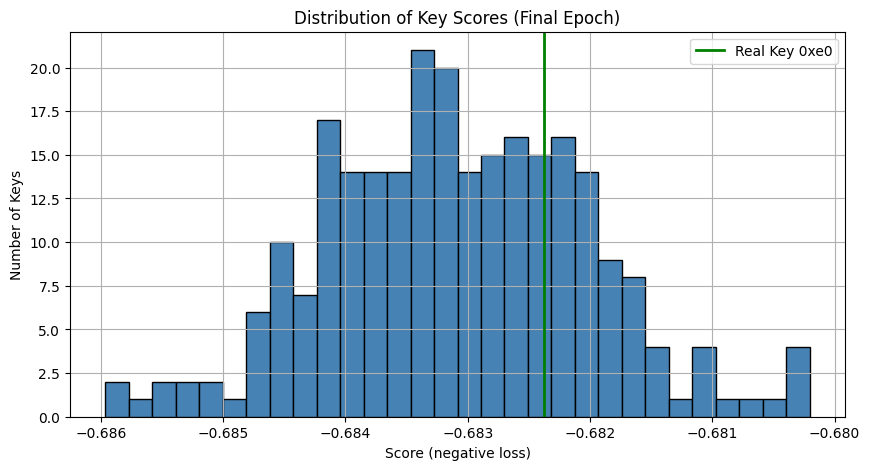

In [7]:
final_scores = key_scores[-1]
epochs_range = np.arange(1, CNN_NUM_EPOCHS + 1)

real_key_ranks = []
for epoch in range(CNN_NUM_EPOCHS):
    sorted_keys = np.argsort(key_scores[epoch])[::-1]
    rank = np.where(sorted_keys == real_key)[0][0] + 1
    real_key_ranks.append(rank)

# Chart 1: Learning Rate Schedule
fig, ax = plt.subplots(figsize=(10, 4))
steps = np.arange(1, len(lr_history) + 1)
ax.plot(steps, lr_history, color='#e63946', linewidth=2)
ax.fill_between(steps, lr_history, alpha=0.3, color='#e63946')
ax.set_xlabel('Training Step')
ax.set_ylabel('Learning Rate')
ax.set_title('OneCycleLR Schedule: Warmup → Peak → Cosine Decay')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Mark phases
warmup_end = int(len(lr_history) * 0.3)
ax.axvline(x=warmup_end, color='#457b9d', linestyle='--', alpha=0.7, label='Warmup End (30%)')
ax.legend()
plt.tight_layout()
plt.show()

# Chart 2: Key Score Evolution
plt.figure(figsize=(10, 5))
sorted_final = np.argsort(final_scores)[::-1]
for k in sorted_final[:5]:
    if k != real_key:
        plt.plot(epochs_range, key_scores[:, k], color='gray', alpha=0.5, linewidth=1)
plt.plot(epochs_range, key_scores[:, real_key], color='green', linewidth=2, 
         marker='o', label=f'Real Key {hex(real_key)}')
plt.xlabel('Epoch')
plt.ylabel('Score (negative loss)')
plt.title('Key Score Evolution Over Training')
plt.legend()
plt.grid(True)
plt.show()

# Chart 3: Score Distribution
plt.figure(figsize=(10, 5))
plt.hist(final_scores, bins=30, color='steelblue', edgecolor='black')
plt.axvline(x=final_scores[real_key], color='green', linewidth=2, label=f'Real Key {hex(real_key)}')
plt.xlabel('Score (negative loss)')
plt.ylabel('Number of Keys')
plt.title('Distribution of Key Scores (Final Epoch)')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
print("=" * 50)
print("ATTACK SUMMARY")
print("=" * 50)
print(f"Target Key Byte:  {hex(real_key)}")
print(f"Final Rank:       {real_key_ranks[-1]}")
print(f"Final Score:      {final_scores[real_key]:.4f}")
if real_key_ranks[-1] == 1:
    print("Result:           KEY RECOVERED!")
else:
    print(f"Result:           Key not recovered (rank {real_key_ranks[-1]})")
print("=" * 50)


ATTACK SUMMARY
Target Key Byte:  0xe0
Final Rank:       69
Final Score:      -0.6824
Result:           Key not recovered (rank 69)


## 8. Save Model


In [ ]:
# Save the trained model with versioned checkpoint
exp = ExperimentManager(checkpoint_dir=CHECKPOINT_DIR)

config_dict = {
    'CNN_LEARNING_RATE': CNN_LEARNING_RATE,
    'CNN_FILTERS': CNN_FILTERS,
    'CNN_KERNEL_1': CNN_KERNEL_1,
    'CNN_KERNEL_2': CNN_KERNEL_2,
    'CNN_POOL_1': CNN_POOL_1,
    'CNN_POOL_2': CNN_POOL_2,
    'CNN_INPUT_SIZE': CNN_INPUT_SIZE,
    'CNN_BATCH_SIZE': CNN_BATCH_SIZE,
    'NUM_TRACES': NUM_TRACES,
    'CNN_NUM_EPOCHS': CNN_NUM_EPOCHS,
    'TARGET_BYTE_IDX': TARGET_BYTE_IDX,
    # OneCycleLR scheduler params
    'LR_MAX': CNN_LEARNING_RATE * 10,
    'LR_PCT_START': 0.3,
    'LR_DIV_FACTOR': 10,
    'LR_FINAL_DIV_FACTOR': 25,
}

# Prepare results with training outcomes
results = {
    'real_key': int(real_key),
    'final_rank': real_key_ranks[-1],
    'final_score': float(final_scores[real_key]),
    'key_recovered': real_key_ranks[-1] == 1,
}

# Save model using ExperimentManager (auto-incrementing run ID)
run_id = exp.save_run(
    model=model,
    model_type='cnn',
    config=config_dict,
    results=results
)

print(f"\nCheckpoint saved with:")
print(f"  - Run ID: {run_id}")
print(f"  - Config: {len(config_dict)} parameters")
print(f"  - Results: Final rank={results['final_rank']}, Key recovered={results['key_recovered']}")


TypeError: Object of type int64 is not JSON serializable